# ML draft

Method and code is adopted from https://github.com/morrismanfung/yukoproject2022/blob/main/02-model/001-knn.ipynb

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
data_full = pd.read_csv( 'data/risk_factors_cervical_cancer.csv')

In [3]:
data_full.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
data_full[ 'target'] = data_full[ 'Hinselmann'] | data_full[ 'Schiller'] | data_full[ 'Citology'] | data_full[ 'Biopsy']
data_full = data_full.replace('?', np.nan)

In [5]:
data_full[ 'target'].value_counts()

0    756
1    102
Name: target, dtype: int64

In [6]:
STDs = ['STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV']

for i in STDs:
    print( i)
    print( data_full[ i].value_counts())
    print()

STDs:condylomatosis
0.0    709
1.0     44
Name: STDs:condylomatosis, dtype: int64

STDs:cervical condylomatosis
0.0    753
Name: STDs:cervical condylomatosis, dtype: int64

STDs:vaginal condylomatosis
0.0    749
1.0      4
Name: STDs:vaginal condylomatosis, dtype: int64

STDs:vulvo-perineal condylomatosis
0.0    710
1.0     43
Name: STDs:vulvo-perineal condylomatosis, dtype: int64

STDs:syphilis
0.0    735
1.0     18
Name: STDs:syphilis, dtype: int64

STDs:pelvic inflammatory disease
0.0    752
1.0      1
Name: STDs:pelvic inflammatory disease, dtype: int64

STDs:genital herpes
0.0    752
1.0      1
Name: STDs:genital herpes, dtype: int64

STDs:molluscum contagiosum
0.0    752
1.0      1
Name: STDs:molluscum contagiosum, dtype: int64

STDs:AIDS
0.0    753
Name: STDs:AIDS, dtype: int64

STDs:HIV
0.0    735
1.0     18
Name: STDs:HIV, dtype: int64



In [7]:
Dxs = ['Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']
for i in Dxs:
    print( i)
    print( data_full[ i].value_counts())
    print()

Dx:Cancer
0    840
1     18
Name: Dx:Cancer, dtype: int64

Dx:CIN
0    849
1      9
Name: Dx:CIN, dtype: int64

Dx:HPV
0    840
1     18
Name: Dx:HPV, dtype: int64

Dx
0    834
1     24
Name: Dx, dtype: int64



In [8]:
numeric_features = [ 'Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']

binary_features = [ 'STDs:condylomatosis', 'Smokes', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann']

columns_tbc = numeric_features+binary_features

column_transformer = make_column_transformer(
    ( make_pipeline( SimpleImputer( strategy = 'median'), StandardScaler()), numeric_features),
    ( make_pipeline( SimpleImputer( strategy = 'constant', fill_value = '99'), OneHotEncoder( handle_unknown = 'ignore')), binary_features)
)

In [9]:
X = data_full[ columns_tbc]
y = data_full[ 'target']

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.5, stratify = y, random_state = 123)

## KNN

In [11]:
pipe_knn = make_pipeline( column_transformer, KNeighborsClassifier()) # No class weight in KNN
cv_result = cross_validate( pipe_knn, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.025004,0.171996,0.000000,0.097561
1,0.010001,0.013000,0.100000,0.292683
2,0.010000,0.012002,0.000000,0.170732
3,0.009000,0.012035,0.090909,0.150000
4,0.009963,0.012214,0.100000,0.146341


In [12]:
param_grid = {
    "kneighborsclassifier__n_neighbors": list( range( 5, 35, 5))
}

grid_search = GridSearchCV(
    pipe_knn, param_grid, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True
)

grid_search.fit( X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False)

,params,mean_test_score
0,{'kneighborsclassifier__n_neighbors': 5},0.058182
1,{'kneighborsclassifier__n_neighbors': 10},0.000000
2,{'kneighborsclassifier__n_neighbors': 15},0.000000
3,{'kneighborsclassifier__n_neighbors': 20},0.000000
4,{'kneighborsclassifier__n_neighbors': 25},0.000000
5,{'kneighborsclassifier__n_neighbors': 30},0.000000


In [13]:
y_hat = grid_search.predict( X_test)

In [14]:
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[373   5]
 [ 43   8]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       378
           1       0.62      0.16      0.25        51

    accuracy                           0.89       429
   macro avg       0.76      0.57      0.59       429
weighted avg       0.86      0.89      0.86       429



## SVC

In [15]:
pipe_svc = make_pipeline( column_transformer, SVC( class_weight = 'balanced'))
cv_result = cross_validate( pipe_svc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.032004,0.013038,0.400000,0.780488
1,0.020007,0.010219,0.300000,0.731707
2,0.018185,0.010997,0.500000,0.853659
3,0.019199,0.009193,0.636364,0.750000
4,0.018000,0.008181,0.800000,0.780488


In [16]:
param_dist = {
    'svc__C': [ 10**x for x in range( -2, 5)],
    'svc__gamma': [ 10**x for x in range( -2, 5)]
}

random_search = RandomizedSearchCV(
    pipe_svc, param_dist, n_iter = 30, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True
)

random_search.fit( X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Number '
                                                                                'of '
                                                                                'sexual '
                                                                                'partners',
                                                                                'First '
                                                                                'sexual '
                                                                                'intercourse',
                                                                                'Num '
                                                                                'of '
                                                                                'pregnancies',
                                                                                'Hormonal '
                                                                                'Contraceptives '
                                                                                '(years)',
                                                                                'I...
                                                                                                              strategy='constant')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['STDs:condylomatosis',
                                                                                'Smokes',
                                                                                'Dx:Cancer',
                                                                                'Dx:CIN',
                                                                                'Dx:HPV',
                                                                                'Hinselmann'])])),
                                             ('svc',
                                              SVC(class_weight='balanced'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100, 1000,
                                                   10000],
                                        'svc__gamma': [0.01, 0.1, 1, 10, 100,
                                                       1000, 10000]},
                   return_train_score=True, scoring='recall')

In [17]:
results = pd.DataFrame( random_search.cv_results_)
results[ ['params', 'mean_test_score', 'mean_train_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score,mean_train_score
19,"{'svc__gamma': 1, 'svc__C': 0.1}",0.900000,0.936341
0,"{'svc__gamma': 0.01, 'svc__C': 1}",0.565455,0.617317
22,"{'svc__gamma': 0.01, 'svc__C': 10}",0.565455,0.745000
15,"{'svc__gamma': 0.1, 'svc__C': 1}",0.527273,0.818537
23,"{'svc__gamma': 0.01, 'svc__C': 1000}",0.450909,0.911829


In [18]:
y_hat = random_search.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[130 248]
 [ 10  41]]
              precision    recall  f1-score   support

           0       0.93      0.34      0.50       378
           1       0.14      0.80      0.24        51

    accuracy                           0.40       429
   macro avg       0.54      0.57      0.37       429
weighted avg       0.84      0.40      0.47       429



Try a less complex model to reduce overfitting.

In [19]:
pipe_svc_opt = make_pipeline( column_transformer, SVC( class_weight = 'balanced', gamma = 10, C = 0.1))
pipe_svc_opt.fit( X_train, y_train)
y_hat = pipe_svc_opt.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[  0 378]
 [  0  51]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       378
           1       0.12      1.00      0.21        51

    accuracy                           0.12       429
   macro avg       0.06      0.50      0.11       429
weighted avg       0.01      0.12      0.03       429



C:\Users\User\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
precision, recall, thresholds = precision_recall_curve( y_test, pipe_svc_opt.decision_function( X_test))

In [21]:
def pr_curve( precision, recall):
    plot_df = pd.DataFrame( {
        'precision': precision,
        'recall': recall
    })

    chart = alt.Chart( plot_df).mark_point().encode(
        x = 'precision',
        y = 'recall'
    ).properties( height = 300, width = 300)
    return chart

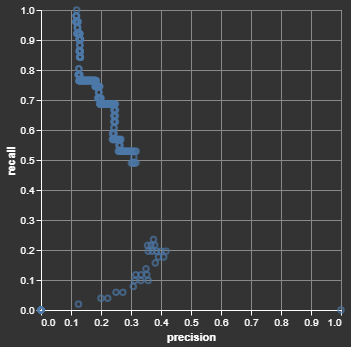

In [22]:
pr_curve( precision, recall)

## Random Forest (Let's give it a try :))

In [23]:
from sklearn.ensemble import RandomForestClassifier
pipe_rfc = make_pipeline( column_transformer, RandomForestClassifier( class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_rfc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.232490,0.023428,0.300000,1.0
1,0.174594,0.021366,0.100000,1.0
2,0.168904,0.020160,0.200000,1.0
3,0.161805,0.021002,0.454545,1.0
4,0.159803,0.020203,0.600000,1.0


In [24]:
param_dist = {
    'randomforestclassifier__n_estimators': [ 100*x for x in range( 1, 11)],
    'randomforestclassifier__max_depth': [ 10*x for x in range( 1, 11)],
    'randomforestclassifier__max_features': [ 'sqrt', 'log2'],
    'randomforestclassifier__criterion': [ 'gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [ True, False]
}

random_search = RandomizedSearchCV(
    pipe_rfc, param_dist, n_iter = 30, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True, random_state = 918
)

random_search.fit( X_train, y_train)

results = pd.DataFrame(random_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
15,"{'randomforestclassifier__n_estimators': 400, ...",0.410909
4,"{'randomforestclassifier__n_estimators': 400, ...",0.410909
12,"{'randomforestclassifier__n_estimators': 300, ...",0.410909
7,"{'randomforestclassifier__n_estimators': 500, ...",0.410909
18,"{'randomforestclassifier__n_estimators': 900, ...",0.410909


In [25]:
print( results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0])
y_hat = random_search.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 90, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
[[372   6]
 [ 31  20]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       378
           1       0.77      0.39      0.52        51

    accuracy                           0.91       429
   macro avg       0.85      0.69      0.74       429
weighted avg       0.90      0.91      0.90       429



In [26]:
precision, recall, thresholds = precision_recall_curve( y_test, random_search.predict_proba( X_test)[:,1])

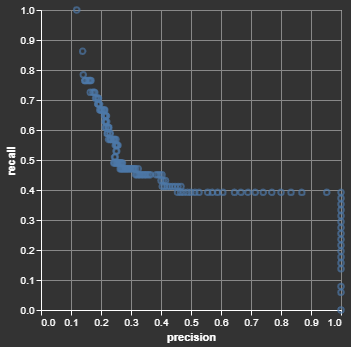

In [27]:
pr_curve( precision, recall)

## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

pipe_nb = make_pipeline( column_transformer, GaussianNB())
cv_result = cross_validate( pipe_nb, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.030002,0.011005,0.300000,0.463415
1,0.021997,0.012998,0.200000,0.463415
2,0.027002,0.017999,0.200000,0.512195
3,0.024000,0.012998,0.545455,0.400000
4,0.014002,0.006999,0.700000,0.390244


In [29]:
pipe_nb.fit( X_train, y_train) # As no hyperparameter optimization for Gaussian naive Bayes
y_hat = pipe_nb.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[369   9]
 [ 28  23]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       378
           1       0.72      0.45      0.55        51

    accuracy                           0.91       429
   macro avg       0.82      0.71      0.75       429
weighted avg       0.90      0.91      0.90       429



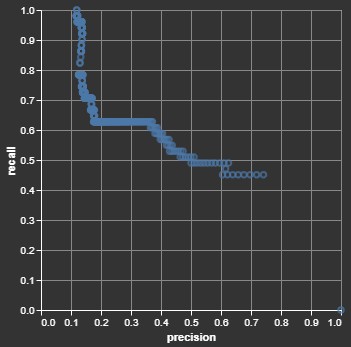

In [30]:
precision, recall, thresholds = precision_recall_curve( y_test, pipe_nb.predict_proba( X_test)[:,1])
pr_curve( precision, recall)

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 1000, solver = 'saga', class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,fit_time,score_time,test_score,train_score
0,0.099001,0.008999,0.700000,0.731707
1,0.199372,0.009991,0.600000,0.731707
2,0.088036,0.009966,0.400000,0.804878
3,0.182240,0.007001,0.909091,0.725000
4,0.122887,0.008149,0.800000,0.731707


In [32]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search = GridSearchCV(
    pipe_logreg, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

grid_search.fit( X_train, y_train)

results = pd.DataFrame( grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,params,mean_test_score
31,"{'logisticregression__C': 1, 'logisticregressi...",0.342924
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.342251
61,"{'logisticregression__C': 1000, 'logisticregre...",0.342251
60,"{'logisticregression__C': 1000, 'logisticregre...",0.342251
59,"{'logisticregression__C': 100, 'logisticregres...",0.342251


In [33]:
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0]

{'logisticregression__C': 1,
 'logisticregression__l1_ratio': 0.5,
 'logisticregression__penalty': 'elasticnet'}

In [34]:
y_hat = grid_search.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[290  88]
 [ 22  29]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       378
           1       0.25      0.57      0.35        51

    accuracy                           0.74       429
   macro avg       0.59      0.67      0.59       429
weighted avg       0.85      0.74      0.78       429



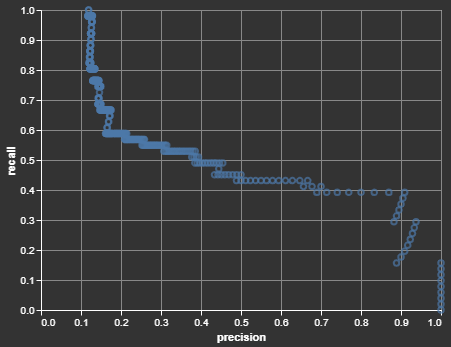

In [43]:
precision, recall, thresholds = precision_recall_curve( y_test, grid_search.predict_proba( X_test)[:,1])
pl_df = pd.DataFrame( {
    'precision': precision,
    'recall': recall})
alt.Chart( pl_df).mark_point().encode(
    x = 'precision', y = 'recall')

In [36]:
plot_df = pd.DataFrame( {
    'precision': precision,
    'recall': recall
})

chart = alt.Chart( plot_df).mark_point().encode(
    x = 'precision',
    y = 'recall'
).properties( height = 300, width = 300)

In [37]:
len( precision), len( thresholds)

(420, 419)

In [38]:
thresholds = np.append( thresholds, 1)

In [39]:
plt_df = pd.DataFrame( {
    'precision': precision,
    'recall': recall,
    'thresholds': thresholds
})

chart = alt.Chart( plt_df).mark_point().encode(
    x = 'thresholds',
    y = 'precision',
).properties( height = 300, width = 300)

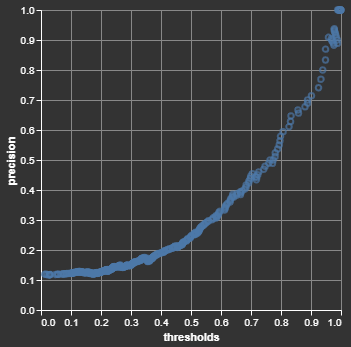

In [40]:
chart

In [41]:
plt_df

,precision,recall,thresholds
0,0.118881,1.000000,0.012569
1,0.119159,1.000000,0.017479
2,0.117096,0.980392,0.022614
3,0.117371,0.980392,0.028135
4,0.117647,0.980392,0.028737
...,...,...,...
415,1.000000,0.078431,0.997124
416,1.000000,0.058824,0.998073
417,1.000000,0.039216,0.999031
418,1.000000,0.019608,0.999091


In [42]:
y_hat = grid_search.predict_proba( X_test)[:,1] > 0.934289
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[373   5]
 [ 31  20]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       378
           1       0.80      0.39      0.53        51

    accuracy                           0.92       429
   macro avg       0.86      0.69      0.74       429
weighted avg       0.91      0.92      0.90       429

